# FIGURE 2

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.figures.figure2 import plotR2YQ2Y, plotMixedClusteringPLSR_GridSearch, plotMeasuredVsPredicted, plotScoresLoadings, plotclusteraverages
from msresist.clustering import MassSpecClustering
from msresist.sequence_analysis import preprocess_seqs, FormatName, pYmotifs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean, LinearFoldChange, FoldChangeToControl, MapOverlappingPeptides, BuildMatrix, TripsMeanAndStd, CorrCoefFilter
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

### Importing and Pre-processing Data

### Phosphorylation measurements:

In [15]:
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [2]:
ABC = preprocessing(motifs=True, Vfilter=True, FCfilter=True, log2T=True)
ABC = preprocess_seqs(ABC, "Y").sort_values(by="Protein")

header = ABC.columns
treatments = ABC.columns[6:]

data = ABC.iloc[:, 6:].T
info = ABC.iloc[:, :6]

In [3]:
ABC

,Protein,Sequence,UniprotAcc,Position,r2_Std,BioReps,PC9,Erl,R428,Erl/R428,Erl+HGF,Erl+FGF,Erl+IGF,KO Erl,KO R428,KO Erl/R428
0,"1-phosphatidylinositol 4,5-bisphosphate phosph...",RNPGFyVEANP,P19174,Y783-p,NA,1,0.891610,-0.132290,0.508638,-0.431225,-0.008149,0.338497,-0.481326,-0.713501,0.547278,-0.519532
3,14-3-3 protein epsilon,GDYHRyLAEFA,P62258,Y131-p,NA,1,0.413272,0.620284,0.352508,-0.291815,0.122734,0.216532,0.167650,-0.586405,-0.395571,-0.619189
4,14-3-3 protein zeta/delta,LLSVAyKNVVG,P63104,Y48-p,NA,1,2.028584,1.620221,1.301309,-0.568873,-0.712916,-0.731959,-0.791261,-0.762381,-0.574292,-0.808433
15,60S ribosomal protein L22-like 1,TYELRyFQISQ,Q6P5R6,Y108-p,NA,1,-0.050440,-0.157775,-0.042431,0.073614,-0.466527,-0.151340,0.006562,-0.384522,1.342117,-0.169258
16,ADP-ribosylation factor-like protein 11,KtTLLyKLKGH,Q969Q4,Y30-p,0.94,2,0.524947,0.122358,0.153717,-0.546423,0.213311,-0.225130,-0.111816,-0.105150,0.030002,-0.055816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,Zinc finger CCCH-type antiviral protein 1,LLSSDyRIING,Q7Z2W4,Y410-p,NA,1,2.169358,1.570918,0.620437,-1.374179,0.289226,-0.012489,0.232086,-0.981527,-1.024902,-1.488927
784,Zinc finger protein 185,LFVKEyVNASE,O15231,Y581-p,0.96,2,2.694753,0.852521,0.959014,-1.434426,0.582779,-0.266371,-0.040972,-1.194264,-0.760311,-1.392723
785,Zinc finger protein 185,PVSARySNVSS,O15231,Y597-p,NA,1,0.577963,0.026361,0.046690,0.203022,0.399508,0.017095,-0.176009,-0.181494,-0.215097,-0.698038
783,Zinc finger protein 185,GALADyEGKDV,O15231,Y408-p,NA,1,1.316789,0.388504,0.263724,-1.455803,0.597152,0.022433,0.432893,-0.449084,-0.012254,-1.104353


### Phenotypes

#### Cell Viability:

In [4]:
Y_cv1 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]
Y_cv2 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw4.csv').iloc[:29, :11]

for ii in range(1, Y_cv2.columns.size):
    Y_cv1.iloc[:, ii] /= Y_cv1.iloc[0, ii]
    Y_cv2.iloc[:, ii] /= Y_cv2.iloc[0, ii]

Y_cv = MergeDfbyMean(pd.concat([Y_cv1, Y_cv2], axis=0), Y_cv1.columns, "Elapsed")
Y_cv = Y_cv.reset_index()[Y_cv1.columns]
Y_cv = Y_cv[Y_cv["Elapsed"] == 72].iloc[0, 1:]

# Chained MS mixed clustering + PLSR analysis

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
convergence has been reached at iteration 19


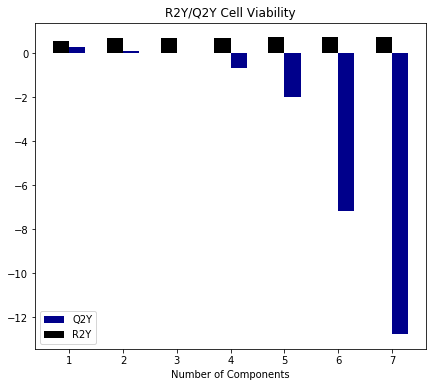

In [7]:
ncl = 7
GMMweight = 0

MSC = MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method="Binomial").fit(data, Y_cv)
centers = MSC.transform(data)

fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, ncl, centers, Y_cv)

In [8]:
# fig, ax = plt.subplots(1, 1, figsize=(8,6))
# plotMixedClusteringPLSR_GridSearch(ax, data, info, Y_cv)

In [9]:
ncomp = 2

mixedCl_plsr = Pipeline([('mixedCl', MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method="PAM250")), ('plsr', PLSRegression(ncomp))])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
convergence has been reached at iteration 14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
convergence has been reached at iteration 13
0
1
2
3
4
5
6
7
8
9
convergence has been reached at iteration 9
0
1
2
3
4
5
6
7
8
9
convergence has been reached at iteration 9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
convergence has been reached at iteration 17
0
1
2
3
4
5
6
7
8
convergence has been reached at iteration 8
0
1
2
3
4
5
6
7
convergence has been reached at iteration 7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
convergence has been reached at iteration 17
0
1
2
3
4
5
6
7
8
convergence has been reached at iteration 8
0
1
2
3
4
5
6
7
8
9
convergence has been reached at iteration 9


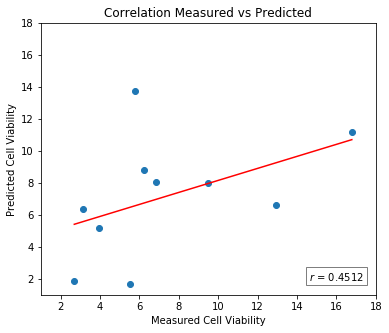

In [10]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plotMeasuredVsPredicted(ax, mixedCl_plsr, data, Y_cv)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
convergence has been reached at iteration 13


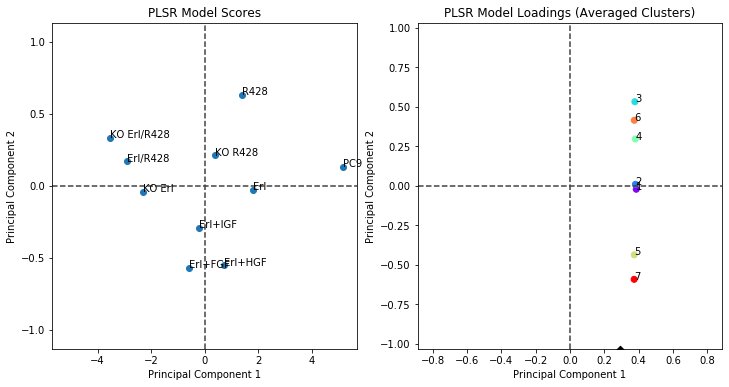

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
colors_ = cm.rainbow(np.linspace(0, 1, ncl))

plotScoresLoadings(ax, mixedCl_plsr, data, Y_cv, ncl, colors_)

In [16]:
clustermembers = mixedCl_plsr.named_steps.mixedCl.clustermembers(ABC.T)
clustermembers

,Cluster_1,seqs_Cluster_1,UniprotAcc_Cluster_1,pos_Cluster_1,r2/Std_Cluster_1,BioReps_Cluster_1,Cluster_2,seqs_Cluster_2,UniprotAcc_Cluster_2,pos_Cluster_2,r2/Std_Cluster_2,BioReps_Cluster_2,Cluster_3,seqs_Cluster_3,UniprotAcc_Cluster_3,pos_Cluster_3,r2/Std_Cluster_3,BioReps_Cluster_3,Cluster_4,seqs_Cluster_4,UniprotAcc_Cluster_4,pos_Cluster_4,r2/Std_Cluster_4,BioReps_Cluster_4,Cluster_5,seqs_Cluster_5,UniprotAcc_Cluster_5,pos_Cluster_5,r2/Std_Cluster_5,BioReps_Cluster_5,Cluster_6,seqs_Cluster_6,UniprotAcc_Cluster_6,pos_Cluster_6,r2/Std_Cluster_6,BioReps_Cluster_6,Cluster_7,seqs_Cluster_7,UniprotAcc_Cluster_7,pos_Cluster_7,r2/Std_Cluster_7,BioReps_Cluster_7
0,Adapter molecule crk,QEEAEyVRALF,P46108,Y136-p,0.85,2,14-3-3 protein zeta/delta,LLSVAyKNVVG,P63104,Y48-p,NA,1,14-3-3 protein epsilon,GDYHRyLAEFA,P62258,Y131-p,NA,1,"1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase gamma-1",RNPGFyVEANP,P19174,Y783-p,NA,1,ADP-ribosylation factor-like protein 11,KtTLLyKLKGH,Q969Q4,Y30-p,0.94,2,60S ribosomal protein L22-like 1,TYELRyFQISQ,Q6P5R6,Y108-p,NA,1,Argininosuccinate synthase,LKGQVyILGRE,P00966,Y359-p,NA,1
1,"Adenylate kinase 2, mitochondrial",AAEPEyPKGIR,P54819,Y12-p,NA,1,ARF GTPase-activating protein GIT1,DDQHDyDSVAS,Q9Y2X7,Y383-p,NA,1,"Actin, cytoplasmic 1",RDLTDyLMKIL,P60709,Y188-p,0.96,2,"Actin, cytoplasmic 1",SLEKsyELPDG,P60709,Y240-p,0.24,3,Actin filament-associated protein 1-like 2,DEEYIyMNKVT,Q8N4X5,Y56-p,NA,1,ADP/ATP translocase 2,ANVIRyFPTQA,P05141,Y81-p,NA,1,Calponin-3,KGMSVyGLGRQ,Q15417,Y261-p,NA,1
2,Alpha-actinin-1,NKHTNyTMEHI,P12814,Y708-p,NA,1,ARF GTPase-activating protein GIT1,GADSDyENTQS,Q9Y2X7,Y598-p,NA,1,Annexin A5,GDTSGyYQRML,P08758,Y148-p,NA,1,Aldo-keto reductase family 1 member C3,KPGLKyKPVCN,P42330,Y184-p,NA,1,Actin filament-associated protein 1-like 2,SPDHLySFRIL,Q8N4X5,Y413-p,NA,1,Abl interactor 2,VVPNDyVPSPT,Q9NYB9,Y213-p,NA,1,Cysteine-rich protein 1,CNKEVyFAERV,P50238,Y12-p,0.59,3
3,Band 4.1-like protein 2,KKQKsyTLVVA,O43491,Y88-p,NA,1,ATPase WRNIP1,AGEEHyNCISA,Q96S55,Y500-p,NA,1,Catenin delta-1,SVSNNyIQTLG,O60716,Y174-p,NA,1,Bcl-2-associated transcription factor 1,NGSSRysPSQN,Q9NYF8,Y284-p,NA,1,"Actin, cytoplasmic 1",LTERGySFTTT,P60709,Y198-p,0.29,3,Actin-related protein 3,EPEDHyFLLTE,P61158,Y109-p,NA,1,Enhancer of filamentation 1,SWMDDyDYVHL,Q14511,Y629-p,0.87,2
4,Brain-specific angiogenesis inhibitor 1-associated protein 2,FKQRPySVAVP,Q9UQB8,Y491-p,NA,1,Aldo-keto reductase family 1 member B1,AIDVGyRHIDC,P15121,Y40-p,NA,1,Desmoplakin,KGGGGyTCQSG,P15924,Y172-p,0.25,3,Beta/gamma crystallin domain-containing protein 2,KGGRGyDRDHV,Q8N1P7,Y1637-p,NA,1,Aldo-keto reductase family 1 member C3,ASHPNyPYSDE,P42330,Y317-p,NA,1,Activated CDC42 kinase 1,VSSTHyYLLPE,Q07912,Y859-p,NA,1,Enhancer of rudimentary homolog,IKEKIyVLLRR,P84090,Y92-p,NA,1
5,Catenin beta-1,AVRLHyGLPVV,P35222,Y489-p,0.83,2,Alpha-actinin-1,DVAEKyLDIPK,P12814,Y215-p,NA,1,Desmoplakin,QNSDGyCQTGT,P15924,Y56-p,0.44,6,Bifunctional purine biosynthesis protein PURH,QMPLRyGMNPH,P31939,Y208-p,NA,1,Annexin A2,DARDLyDAGVK,P07355,Y199-p,NA,1,Activator of 90 kDa heat shock protein ATPase homolog 1,QGWQRyYFEGI,O95433,Y322-p,0.93,2,Fructose-bisphosphate aldolase A,LKRCQyVTEKV,P04075,Y204-p,NA,1
6,Catenin delta-1,RIEERyRPSME,O60716,Y241-p,NA,1,Alpha-actinin-1,YVSSFyHAFSG,P12814,Y246-p,NA,1,Disintegrin and metalloproteinase domain-containing protein 9,REVPIyANRFA,Q13443,Y769-p,0.94,2,Breast cancer anti-estrogen resistance protein 1,ILVGMyDKKPA,P56945,Y67-p,NA,1,Band 4.1-like protein 2,EGDNIyVRHSN,O43491,Y623-p,0.46,4,Afadin,TYTREyFTFPA,P55196,Y1230-p,0.63,2,GRB2-associated-binding protein 2,FRDSTyDLPRS,Q9UQC2,Y266-p,NA,1
7,Enhancer of filamentation 1,EYPSRyQKDVY,Q14511,Y172-p,NA,1,Alpha-actinin-4,EVAEKyLDIPK,O43707,Y234-p,NA,1,"Dynein light chain 1, cytoplasmic",RNFGSyVTHET,P63167,Y65-p,NA,1,Breast cancer anti-estrogen resistance protein 1,PAPDLyDVPPG,P56945,Y372-p,NA,1,Catenin delta-1,FHPEPyGLEDD,O60716,Y280-p,NA,1,Annexin A2,GKsLYyYIQQD,P07355,Y317-p,NA,1

In [ ]:
create_download_link(clustermembers, "DataClustering")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotclusteraverages(ax, ABC, mixedCl_plsr, colors_)